In [1]:
!pip install timm -q

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR100

import timm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support
import time
from tqdm import tqdm
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')
if torch.cuda.is_available():
    print(f'GPU: {torch.cuda.get_device_name(0)}')
    print(f'Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB')

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

Device: cuda
GPU: Tesla P100-PCIE-16GB
Memory: 15.9 GB


In [3]:
EPOCHS = 5
BATCH_SIZE = 32
LEARNING_RATE = 1e-4
NUM_WORKERS = 2

In [4]:
transform_train = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomCrop(224, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5071, 0.4867, 0.4408], std=[0.2675, 0.2565, 0.2761])
])

transform_test = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5071, 0.4867, 0.4408], std=[0.2675, 0.2565, 0.2761])
])

train_dataset = CIFAR100(root='./data', train=True, download=True, transform=transform_train)
test_dataset = CIFAR100(root='./data', train=False, download=True, transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, 
                         num_workers=NUM_WORKERS, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, 
                        num_workers=NUM_WORKERS, pin_memory=True)

print(f'Training: {len(train_dataset)} samples')
print(f'Testing: {len(test_dataset)} samples')

Training: 50000 samples
Testing: 10000 samples


In [5]:
def create_model(model_name):
    if model_name == 'vit':
        model = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=100)
    elif model_name == 'swin':
        model = timm.create_model('swin_base_patch4_window7_224', pretrained=True, num_classes=100)
    elif model_name == 'deit':
        model = timm.create_model('deit_base_patch16_224', pretrained=True, num_classes=100)
    return model.to(device)

def count_parameters(model):
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return {
        'total': total,
        'trainable': trainable,
        'non_trainable': total - trainable,
        'size_mb': total * 4 / (1024 ** 2)
    }

In [6]:
def train_epoch(model, loader, criterion, optimizer):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for inputs, targets in tqdm(loader, desc='Training'):
        inputs, targets = inputs.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    
    return total_loss / total, 100. * correct / total

def validate(model, loader, criterion):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, targets in tqdm(loader, desc='Validation'):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            total_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    
    return total_loss / total, 100. * correct / total

In [7]:
def train_model(model, train_loader, test_loader, epochs, lr):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=0.01)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    best_acc = 0
    
    for epoch in range(epochs):
        print(f'\nEpoch {epoch+1}/{epochs}')
        
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer)
        val_loss, val_acc = validate(model, test_loader, criterion)
        
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        scheduler.step()
        
        print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%')
        
        if val_acc > best_acc:
            best_acc = val_acc
    
    return history, best_acc

In [8]:
def evaluate_model(model, loader):
    model.eval()
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for inputs, targets in tqdm(loader, desc='Evaluating'):
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(targets.numpy())
    
    all_preds = np.array(all_preds)
    all_targets = np.array(all_targets)
    
    acc = accuracy_score(all_targets, all_preds)
    p, r, f1, _ = precision_recall_fscore_support(all_targets, all_preds, average='weighted', zero_division=0)
    
    return {
        'accuracy': acc * 100,
        'precision': p * 100,
        'recall': r * 100,
        'f1_score': f1 * 100,
        'predictions': all_preds,
        'targets': all_targets
    }

In [9]:
def measure_inference_time(model, loader, num_iterations=100):
    model.eval()
    times = []
    
    with torch.no_grad():
        for i, (inputs, _) in enumerate(loader):
            if i >= num_iterations:
                break
            
            inputs = inputs.to(device)
            
            if i >= 10:
                torch.cuda.synchronize()
                start = time.time()
                _ = model(inputs)
                torch.cuda.synchronize()
                end = time.time()
                times.append((end - start) / inputs.size(0))
            else:
                _ = model(inputs)
    
    avg_time = np.mean(times) * 1000
    std_time = np.std(times) * 1000
    throughput = 1000 / avg_time
    
    return {
        'avg_time_ms': avg_time,
        'std_time_ms': std_time,
        'throughput_fps': throughput
    }

In [10]:
def plot_training_history(histories, model_names):
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    for name, history in zip(model_names, histories):
        epochs = range(1, len(history['train_loss']) + 1)
        axes[0, 0].plot(epochs, history['train_loss'], label=name, marker='o')
        axes[0, 1].plot(epochs, history['val_loss'], label=name, marker='o')
        axes[1, 0].plot(epochs, history['train_acc'], label=name, marker='o')
        axes[1, 1].plot(epochs, history['val_acc'], label=name, marker='o')
    
    axes[0, 0].set_title('Training Loss', fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    axes[0, 1].set_title('Validation Loss', fontsize=14, fontweight='bold')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    axes[1, 0].set_title('Training Accuracy', fontsize=14, fontweight='bold')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Accuracy (%)')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    axes[1, 1].set_title('Validation Accuracy', fontsize=14, fontweight='bold')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Accuracy (%)')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
    plt.show()

In [11]:
def plot_confusion_matrix(cm, model_name):
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, cmap='Blues', cbar_kws={'label': 'Count'})
    plt.title(f'Confusion Matrix - {model_name}', fontsize=16, fontweight='bold')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig(f'confusion_matrix_{model_name.lower().replace(" ", "_")}.png', dpi=300, bbox_inches='tight')
    plt.show()

In [12]:
def plot_metrics_comparison(results_dict):
    model_names = list(results_dict.keys())
    metrics = ['accuracy', 'precision', 'recall', 'f1_score']
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes = axes.ravel()
    
    for idx, metric in enumerate(metrics):
        values = [results_dict[name]['metrics'][metric] for name in model_names]
        bars = axes[idx].bar(model_names, values, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
        axes[idx].set_title(metric.replace('_', ' ').title(), fontsize=14, fontweight='bold')
        axes[idx].set_ylabel('Score (%)')
        axes[idx].set_ylim([0, 105])
        axes[idx].grid(True, alpha=0.3, axis='y')
        
        for bar in bars:
            height = bar.get_height()
            axes[idx].text(bar.get_x() + bar.get_width()/2., height,
                          f'{height:.2f}%', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('metrics_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

In [13]:
def plot_parameter_comparison(results_dict):
    model_names = list(results_dict.keys())
    total_params = [results_dict[name]['params']['total'] / 1e6 for name in model_names]
    model_sizes = [results_dict[name]['params']['size_mb'] for name in model_names]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    bars1 = ax1.bar(model_names, total_params, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
    ax1.set_title('Total Parameters', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Parameters (Millions)')
    ax1.grid(True, alpha=0.3, axis='y')
    for bar in bars1:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height, f'{height:.2f}M',
                ha='center', va='bottom', fontweight='bold')
    
    bars2 = ax2.bar(model_names, model_sizes, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
    ax2.set_title('Model Size', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Size (MB)')
    ax2.grid(True, alpha=0.3, axis='y')
    for bar in bars2:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height, f'{height:.2f} MB',
                ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('parameter_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

In [14]:
def plot_inference_time_comparison(results_dict):
    model_names = list(results_dict.keys())
    avg_times = [results_dict[name]['inference']['avg_time_ms'] for name in model_names]
    throughputs = [results_dict[name]['inference']['throughput_fps'] for name in model_names]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    bars1 = ax1.bar(model_names, avg_times, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
    ax1.set_title('Average Inference Time', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Time (ms)')
    ax1.grid(True, alpha=0.3, axis='y')
    for bar in bars1:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height, f'{height:.2f} ms',
                ha='center', va='bottom', fontweight='bold')
    
    bars2 = ax2.bar(model_names, throughputs, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
    ax2.set_title('Throughput', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Images/Second')
    ax2.grid(True, alpha=0.3, axis='y')
    for bar in bars2:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height, f'{height:.2f} fps',
                ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('inference_time_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

In [15]:
models_to_compare = ['vit', 'swin', 'deit']
model_display_names = ['ViT', 'Swin Transformer', 'DeiT']
results = {}
histories = []

In [16]:
for model_name, display_name in zip(models_to_compare, model_display_names):
    print(f'\n{"="*70}')
    print(f'{display_name}')
    print(f'{"="*70}')
    
    model = create_model(model_name)
    params = count_parameters(model)
    
    print(f'Parameters: {params["total"]:,}')
    print(f'Size: {params["size_mb"]:.2f} MB')
    
    history, best_acc = train_model(model, train_loader, test_loader, EPOCHS, LEARNING_RATE)
    histories.append(history)
    
    metrics = evaluate_model(model, test_loader)
    inference = measure_inference_time(model, test_loader)
    
    results[display_name] = {
        'model': model,
        'params': params,
        'history': history,
        'metrics': metrics,
        'inference': inference,
        'best_acc': best_acc
    }
    
    torch.save(model.state_dict(), f'{model_name}_cifar100.pth')
    torch.cuda.empty_cache()


ViT
Parameters: 85,875,556
Size: 327.59 MB

Epoch 1/5


Validation: 100%|██████████| 313/313 [00:58<00:00,  5.36it/s]


Train Loss: 1.0243 | Train Acc: 72.10%
Val Loss: 0.6482 | Val Acc: 80.96%

Epoch 2/5


Validation: 100%|██████████| 313/313 [00:58<00:00,  5.36it/s]


Train Loss: 0.4755 | Train Acc: 85.45%
Val Loss: 0.7557 | Val Acc: 79.15%

Epoch 3/5


Validation: 100%|██████████| 313/313 [00:58<00:00,  5.35it/s]


Train Loss: 0.2505 | Train Acc: 91.94%
Val Loss: 0.5869 | Val Acc: 84.22%

Epoch 4/5


Validation: 100%|██████████| 313/313 [00:58<00:00,  5.35it/s]


Train Loss: 0.0913 | Train Acc: 96.92%
Val Loss: 0.5227 | Val Acc: 86.42%

Epoch 5/5


Validation: 100%|██████████| 313/313 [00:58<00:00,  5.35it/s]


Train Loss: 0.0256 | Train Acc: 99.24%
Val Loss: 0.4910 | Val Acc: 88.80%


Evaluating: 100%|██████████| 313/313 [00:58<00:00,  5.36it/s]



Swin Transformer


model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

Parameters: 86,845,724
Size: 331.29 MB

Epoch 1/5


Validation: 100%|██████████| 313/313 [01:06<00:00,  4.70it/s]


Train Loss: 0.7128 | Train Acc: 80.49%
Val Loss: 0.4582 | Val Acc: 86.80%

Epoch 2/5


Validation: 100%|██████████| 313/313 [01:06<00:00,  4.71it/s]


Train Loss: 0.3115 | Train Acc: 90.44%
Val Loss: 0.4165 | Val Acc: 88.08%

Epoch 3/5


Validation: 100%|██████████| 313/313 [01:06<00:00,  4.70it/s]


Train Loss: 0.1681 | Train Acc: 94.59%
Val Loss: 0.3923 | Val Acc: 89.15%

Epoch 4/5


Validation: 100%|██████████| 313/313 [01:06<00:00,  4.71it/s]


Train Loss: 0.0720 | Train Acc: 97.71%
Val Loss: 0.3484 | Val Acc: 90.97%

Epoch 5/5


Validation: 100%|██████████| 313/313 [01:06<00:00,  4.71it/s]


Train Loss: 0.0289 | Train Acc: 99.17%
Val Loss: 0.3272 | Val Acc: 92.05%


Evaluating: 100%|██████████| 313/313 [01:06<00:00,  4.71it/s]



DeiT


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Parameters: 85,875,556
Size: 327.59 MB

Epoch 1/5


Validation: 100%|██████████| 313/313 [00:58<00:00,  5.35it/s]


Train Loss: 0.8324 | Train Acc: 77.73%
Val Loss: 0.5334 | Val Acc: 83.91%

Epoch 2/5


Validation: 100%|██████████| 313/313 [00:58<00:00,  5.35it/s]


Train Loss: 0.3115 | Train Acc: 90.27%
Val Loss: 0.5144 | Val Acc: 84.70%

Epoch 3/5


Validation: 100%|██████████| 313/313 [00:58<00:00,  5.35it/s]


Train Loss: 0.1490 | Train Acc: 95.19%
Val Loss: 0.4778 | Val Acc: 86.57%

Epoch 4/5


Validation: 100%|██████████| 313/313 [00:58<00:00,  5.35it/s]


Train Loss: 0.0577 | Train Acc: 98.29%
Val Loss: 0.4357 | Val Acc: 88.78%

Epoch 5/5


Validation: 100%|██████████| 313/313 [00:58<00:00,  5.35it/s]


Train Loss: 0.0212 | Train Acc: 99.47%
Val Loss: 0.3949 | Val Acc: 89.74%


Evaluating: 100%|██████████| 313/313 [00:58<00:00,  5.36it/s]


In [17]:
summary_data = []
for name in model_display_names:
    r = results[name]
    summary_data.append({
        'Model': name,
        'Total Params (M)': f"{r['params']['total']/1e6:.2f}",
        'Size (MB)': f"{r['params']['size_mb']:.2f}",
        'Accuracy (%)': f"{r['metrics']['accuracy']:.2f}",
        'Precision (%)': f"{r['metrics']['precision']:.2f}",
        'Recall (%)': f"{r['metrics']['recall']:.2f}",
        'F1-Score (%)': f"{r['metrics']['f1_score']:.2f}",
        'Inference (ms)': f"{r['inference']['avg_time_ms']:.2f}",
        'Throughput (fps)': f"{r['inference']['throughput_fps']:.2f}"
    })

df_summary = pd.DataFrame(summary_data)
print('\n' + '='*100)
print('RESULTS')
print('='*100)
print(df_summary.to_string(index=False))
df_summary.to_csv('results_summary.csv', index=False)


RESULTS
           Model Total Params (M) Size (MB) Accuracy (%) Precision (%) Recall (%) F1-Score (%) Inference (ms) Throughput (fps)
             ViT            85.88    327.59        88.80         89.08      88.80        88.83           5.71           175.00
Swin Transformer            86.85    331.29        92.05         92.17      92.05        92.06           6.52           153.40
            DeiT            85.88    327.59        89.74         89.92      89.74        89.75           5.71           174.99


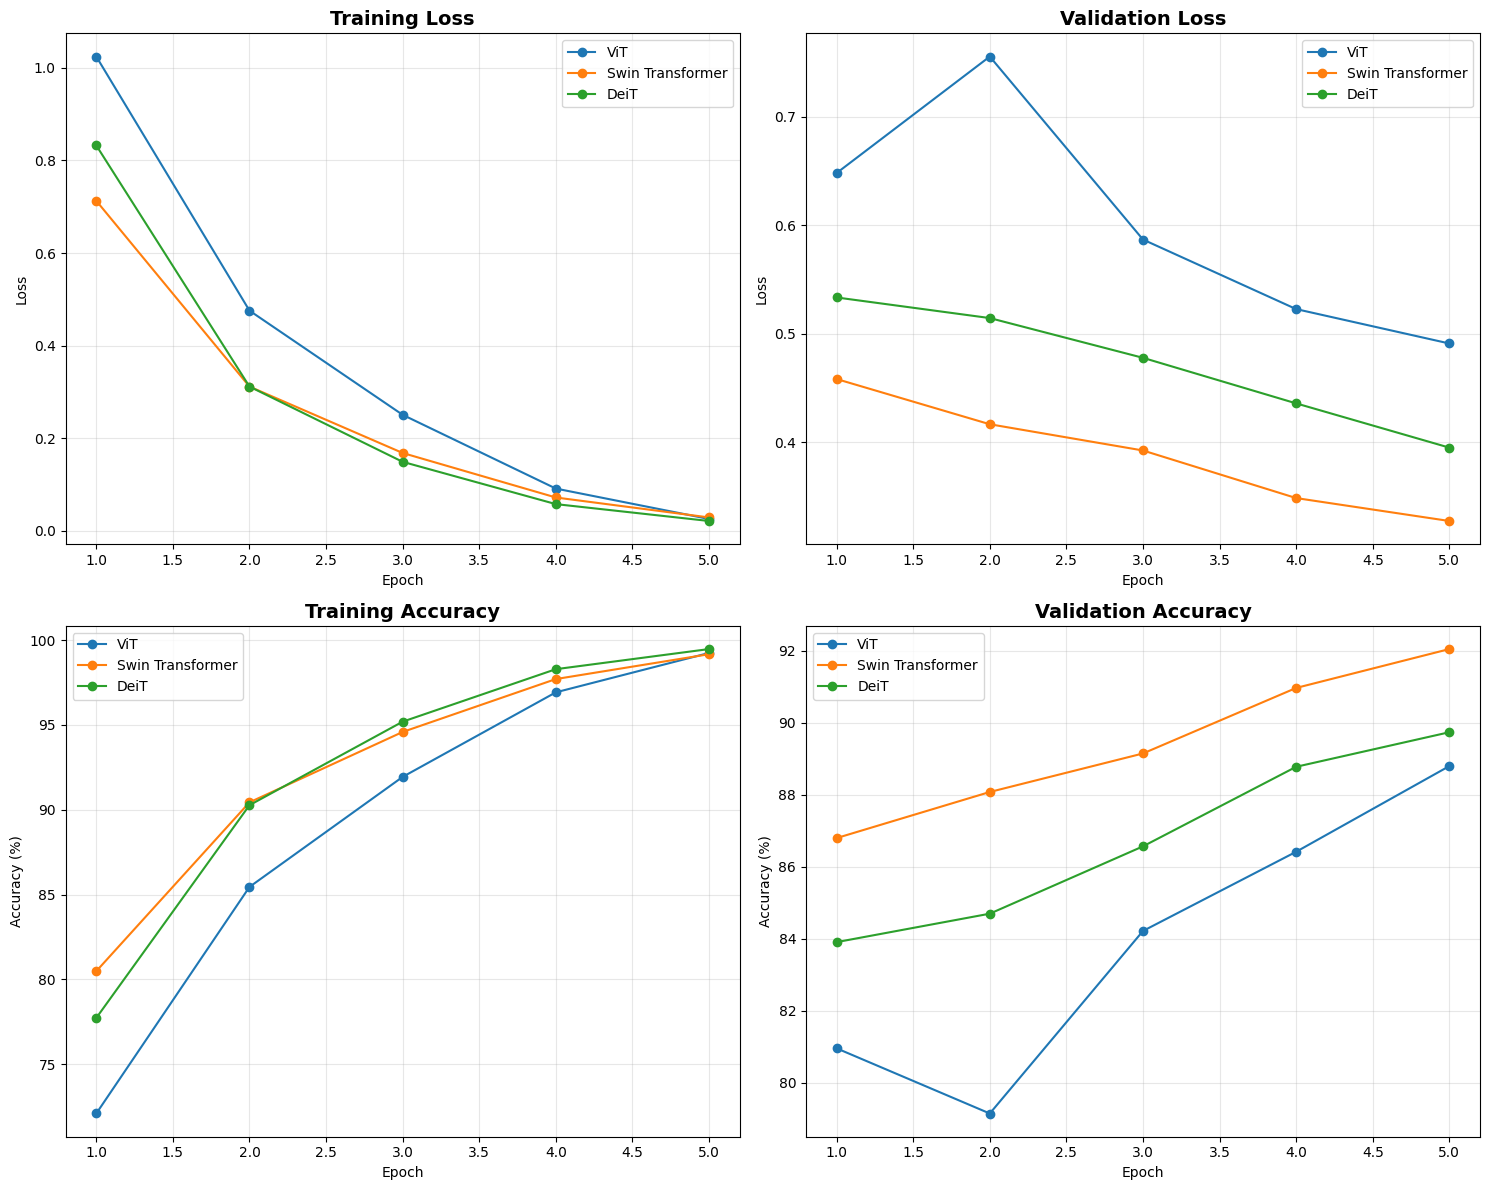

In [18]:
plot_training_history(histories, model_display_names)

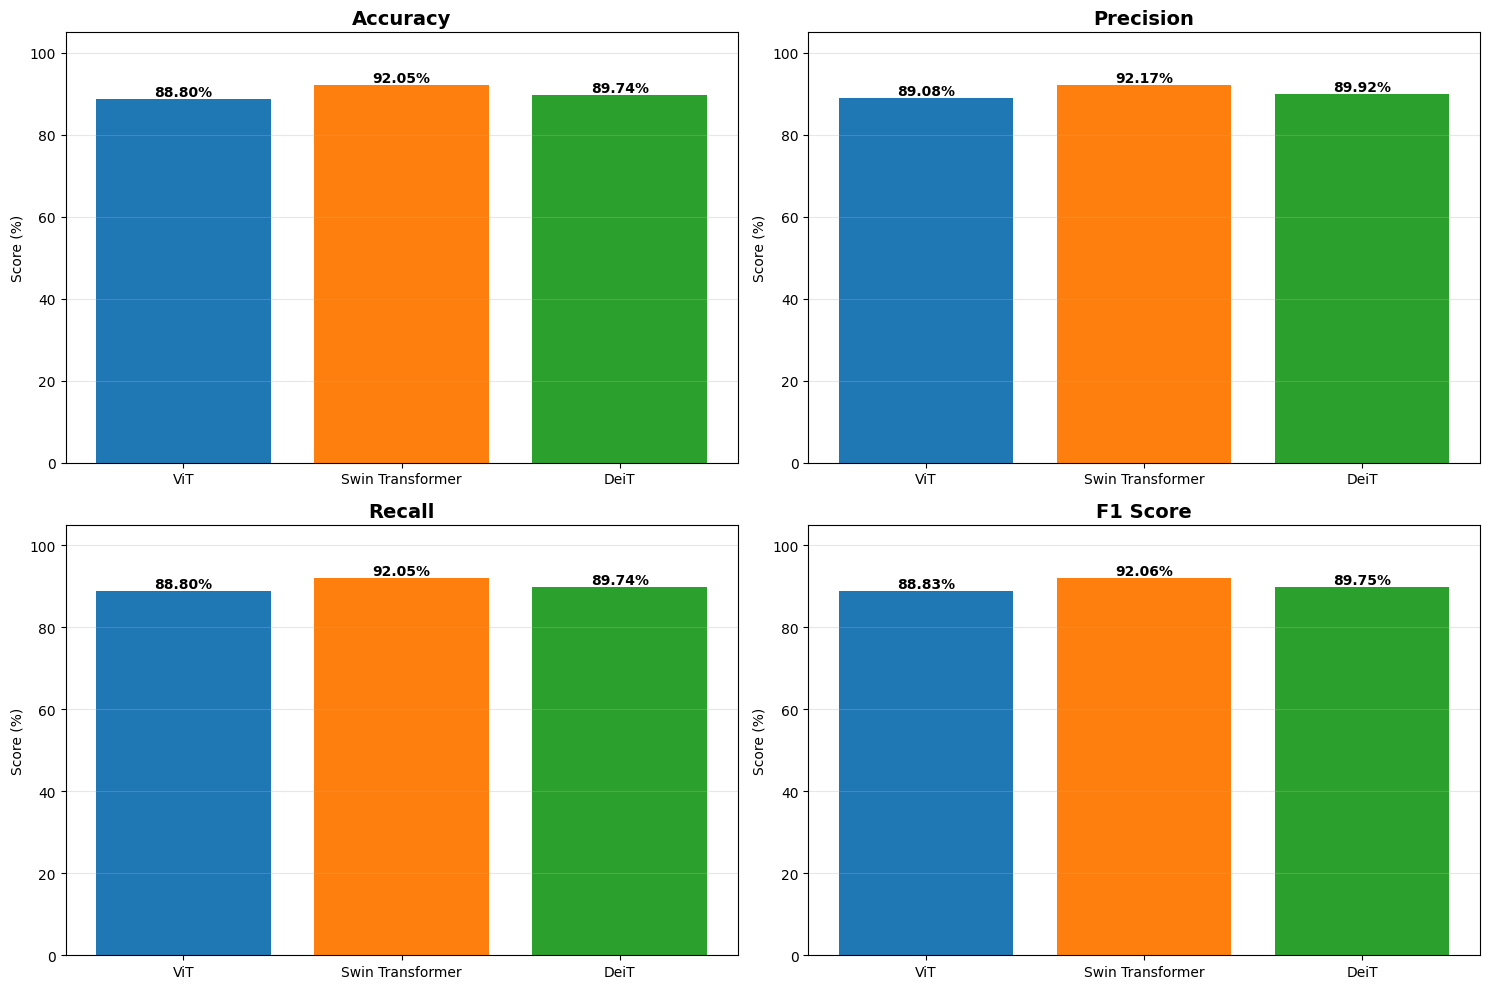

In [19]:
plot_metrics_comparison(results)

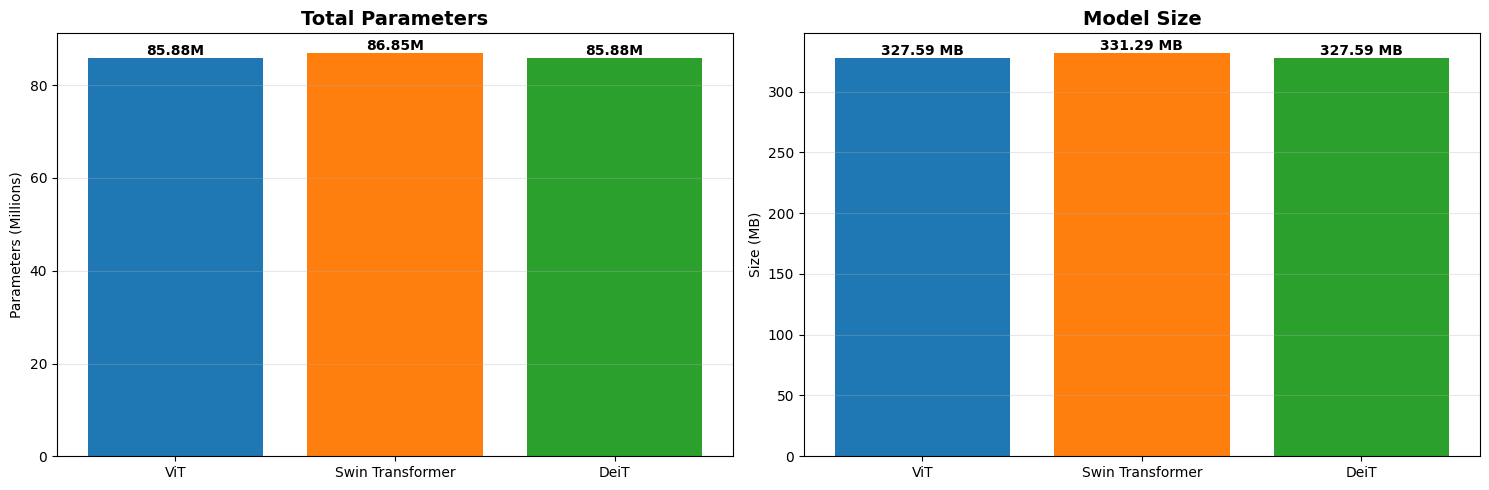

In [20]:
plot_parameter_comparison(results)

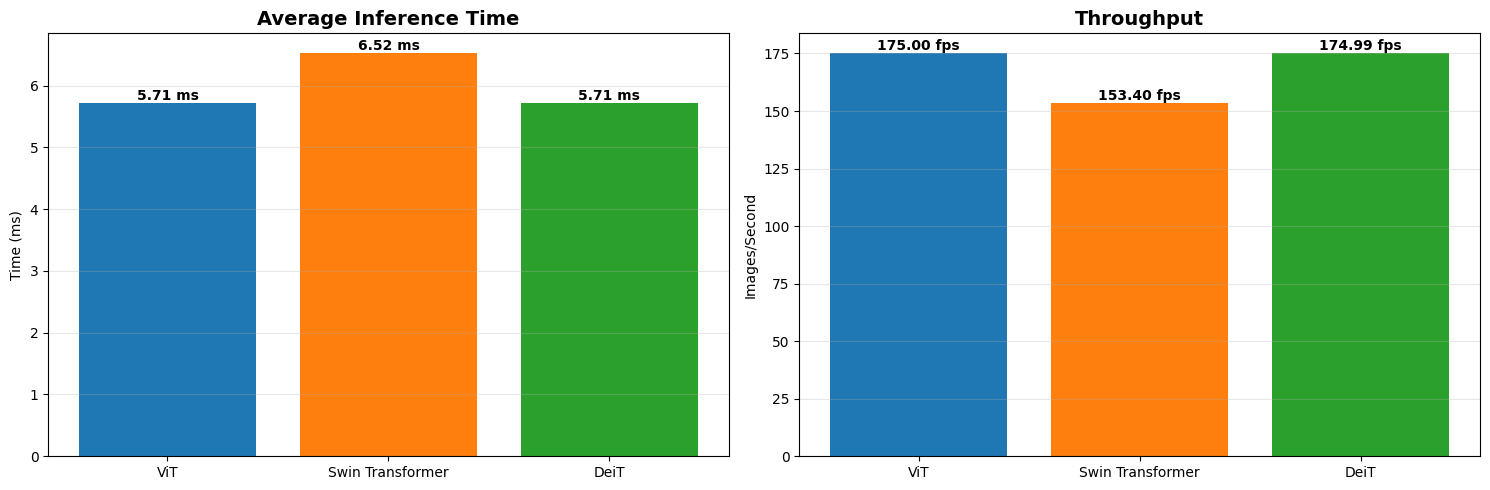

In [21]:
plot_inference_time_comparison(results)

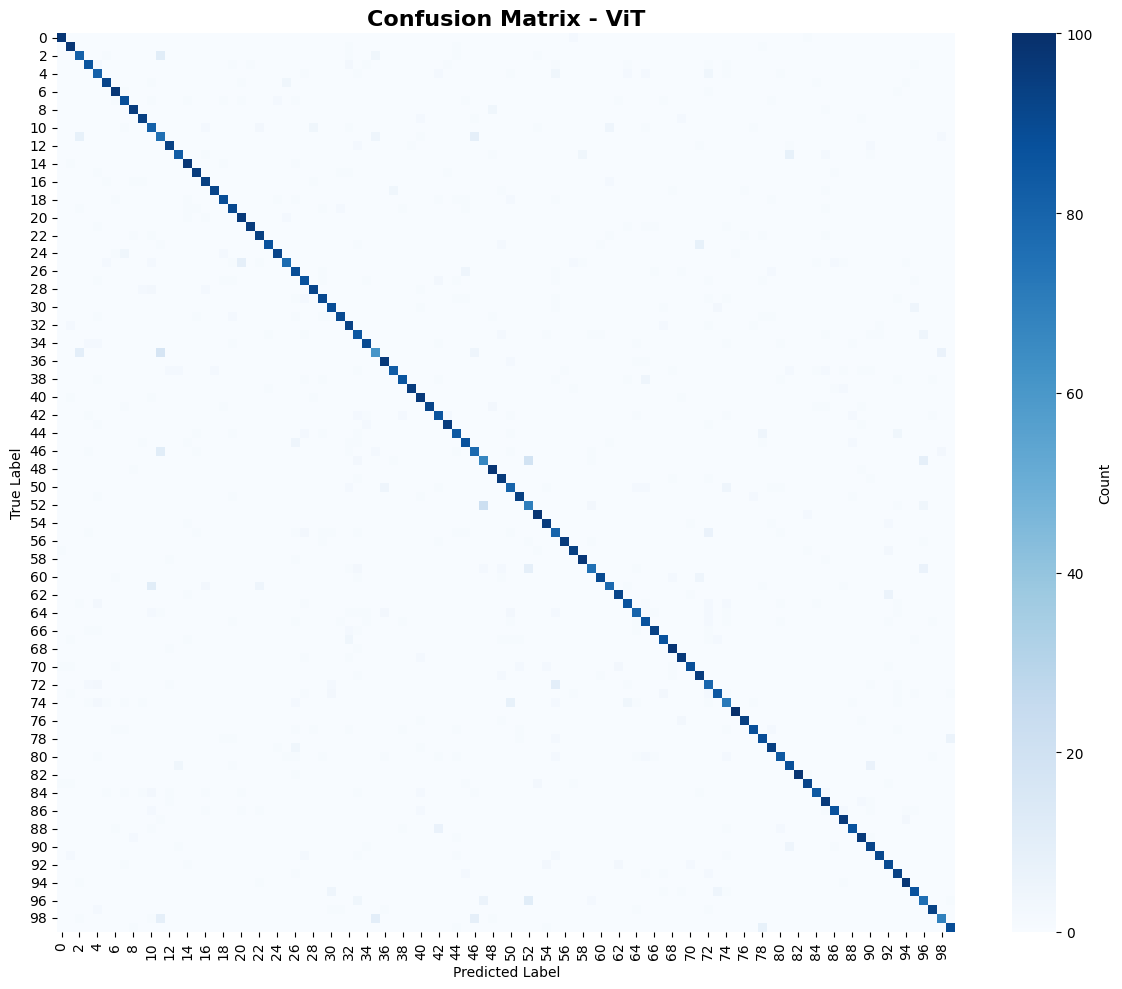

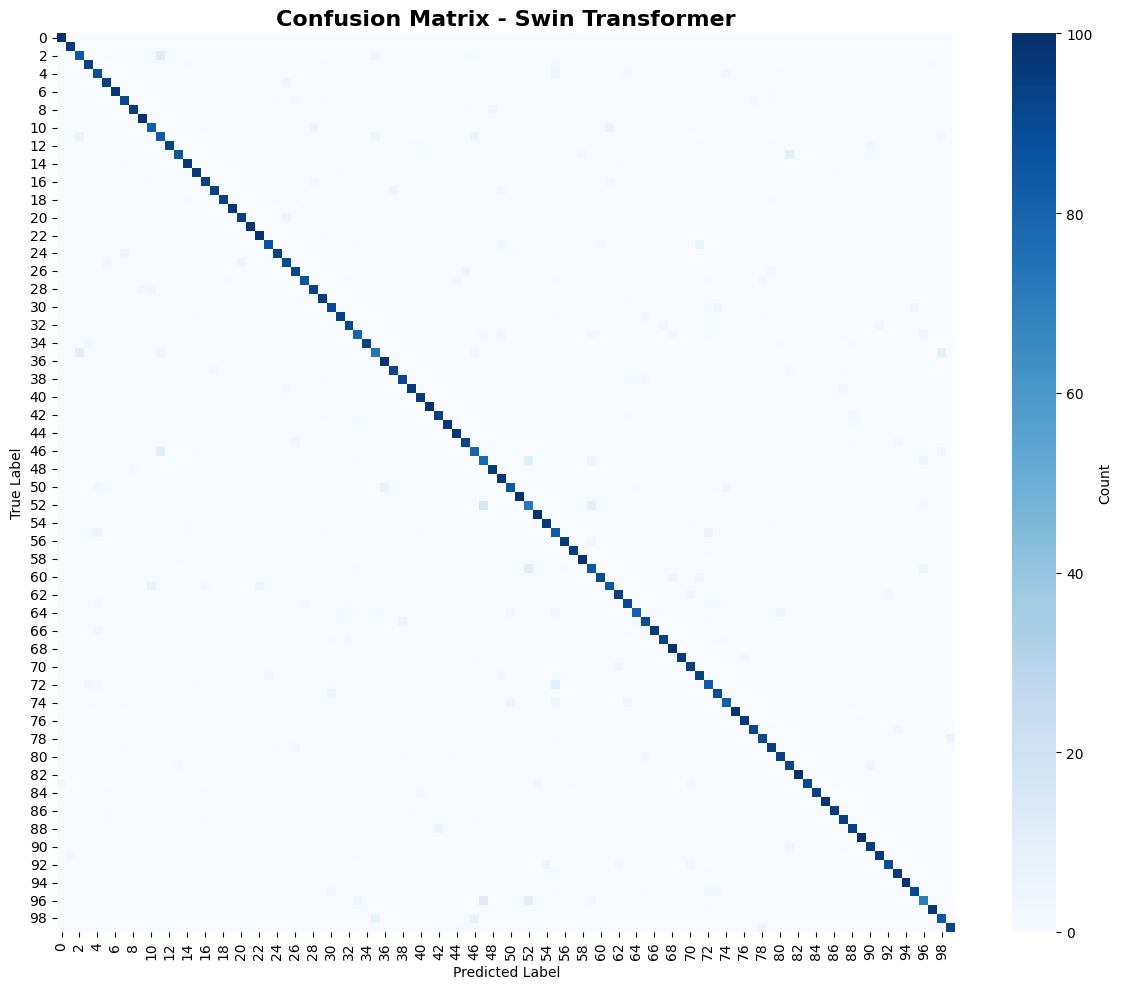

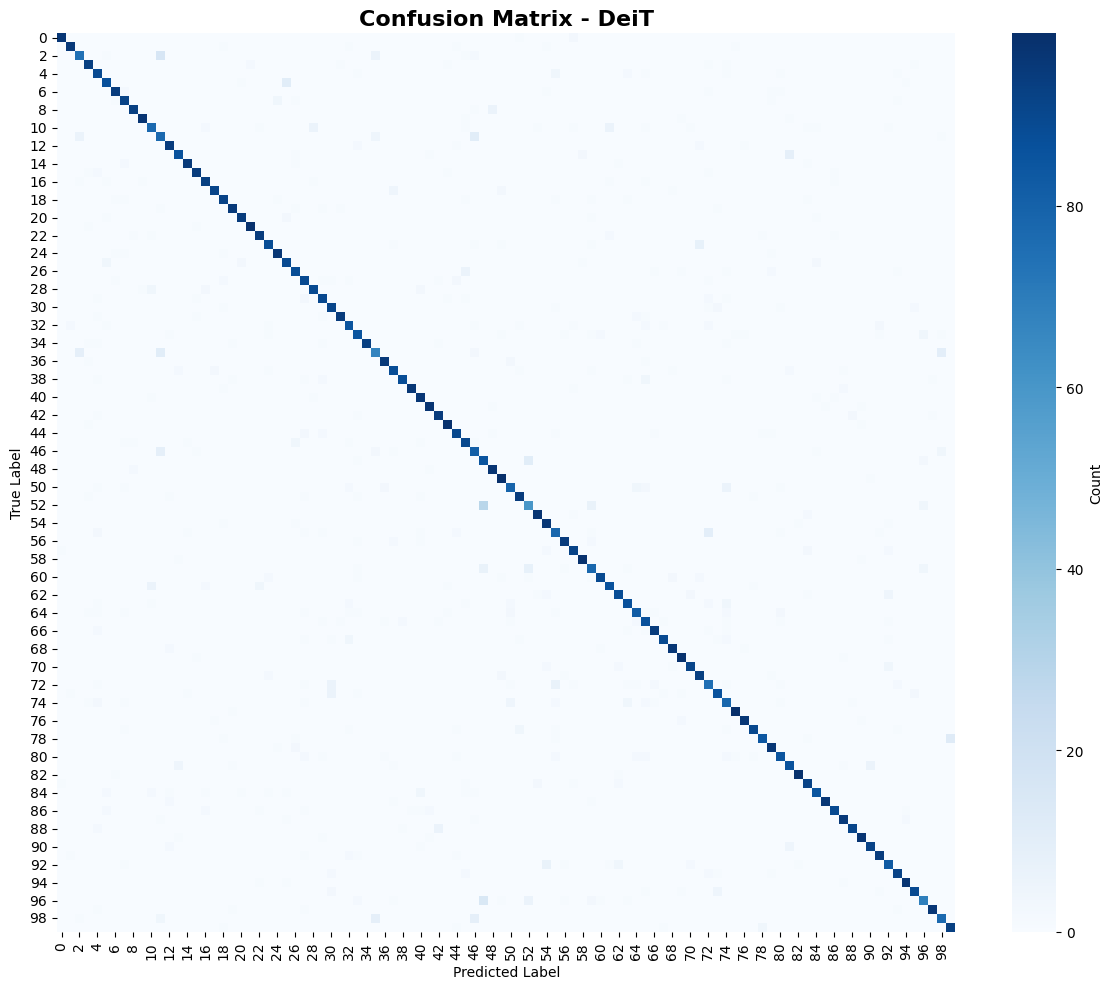

In [22]:
for name in model_display_names:
    cm = confusion_matrix(results[name]['metrics']['targets'], results[name]['metrics']['predictions'])
    plot_confusion_matrix(cm, name)

In [23]:
for name in model_display_names:
    print(f'\n{name}')
    print('-' * 50)
    r = results[name]
    print(f"Accuracy: {r['metrics']['accuracy']:.2f}%")
    print(f"Precision: {r['metrics']['precision']:.2f}%")
    print(f"Recall: {r['metrics']['recall']:.2f}%")
    print(f"F1-Score: {r['metrics']['f1_score']:.2f}%")
    print(f"Inference Time: {r['inference']['avg_time_ms']:.2f} ± {r['inference']['std_time_ms']:.2f} ms")
    print(f"Throughput: {r['inference']['throughput_fps']:.2f} images/second")
    print(f"Parameters: {r['params']['total']:,}")
    print(f"Size: {r['params']['size_mb']:.2f} MB")


ViT
--------------------------------------------------
Accuracy: 88.80%
Precision: 89.08%
Recall: 88.80%
F1-Score: 88.83%
Inference Time: 5.71 ± 0.01 ms
Throughput: 175.00 images/second
Parameters: 85,875,556
Size: 327.59 MB

Swin Transformer
--------------------------------------------------
Accuracy: 92.05%
Precision: 92.17%
Recall: 92.05%
F1-Score: 92.06%
Inference Time: 6.52 ± 0.02 ms
Throughput: 153.40 images/second
Parameters: 86,845,724
Size: 331.29 MB

DeiT
--------------------------------------------------
Accuracy: 89.74%
Precision: 89.92%
Recall: 89.74%
F1-Score: 89.75%
Inference Time: 5.71 ± 0.02 ms
Throughput: 174.99 images/second
Parameters: 85,875,556
Size: 327.59 MB


In [24]:
import pickle

results_save = {}
for name in model_display_names:
    results_save[name] = {
        'params': results[name]['params'],
        'history': results[name]['history'],
        'metrics': results[name]['metrics'],
        'inference': results[name]['inference'],
        'best_acc': results[name]['best_acc']
    }

with open('results.pkl', 'wb') as f:
    pickle.dump(results_save, f)

print('Results saved')

Results saved
